# Labeled CVAE

In [1]:
import sys
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
# Load pallets library

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from pallets import images as I, datasets as DS, models as M, logging as L


# Settings

In [3]:
SAVE_NAME = 'cvae.labeled'

In [4]:
USE_GPU = True
LOG_LEVEL = 'INFO'
LABELS_FILE = 'pallets_labels.json'

TEST_SIZE = 1000
EPOCHS = 50
LR = 1e-03
BATCH_SIZE = 32


In [5]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
L.init_logger(level=LOG_LEVEL, notebook=True)


<Logger pallets (INFO)>

## Prepare Datasets

In [6]:
all_colors = I.get_punk_colors()
mapper = DS.ColorOneHotMapper(all_colors)
dataset = DS.OneHotCPunksDataset(
    mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
)

# Uncomment to put entire dataset in GPU RAM
# dataset = DS.FastOneHotCPunksDataset(
#     device, mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
# )

In [7]:
train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

## Labeled Naive CVAE

In [8]:
input_dim = 24 * 24 * 222
hidden_dim = 576
latent_dim = 32
classes_dim = len(dataset._label_keys)  # 92


In [9]:
model = M.cvae.LabeledCVAE(input_dim, hidden_dim, latent_dim, classes_dim)
criterion = M.cvae.Loss()

train_losses, test_losses = M.cvae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS, conditional_loss=True
)

M.save(SAVE_NAME, model, train_losses, test_losses)

INFO | model: pallets.models.cvae.LabeledCVAE
INFO | criterion: pallets.models.cvae.Loss
INFO | learn rate: 0.001
INFO | epochs: 50
INFO | epoch 1 (  0%) loss: 1423938.500000
INFO | epoch 1 ( 35%) loss: 89962.270885
INFO | epoch 1 ( 70%) loss: 50939.262098
INFO | epoch 1 (100%) loss: 38575.764303
INFO | epoch 1 (test) loss: 6941.493267
INFO | epoch 2 (  0%) loss: 6994.135254
INFO | epoch 2 ( 35%) loss: 6322.110313
INFO | epoch 2 ( 70%) loss: 5699.957447
INFO | epoch 2 (100%) loss: 5270.817404
INFO | epoch 2 (test) loss: 3822.044807
INFO | epoch 3 (  0%) loss: 3979.896240
INFO | epoch 3 ( 35%) loss: 3646.543061
INFO | epoch 3 ( 70%) loss: 3416.485682
INFO | epoch 3 (100%) loss: 3275.893153
INFO | epoch 3 (test) loss: 2721.784670
INFO | epoch 4 (  0%) loss: 2889.577637
INFO | epoch 4 ( 35%) loss: 2608.941902
INFO | epoch 4 ( 70%) loss: 2510.254811
INFO | epoch 4 (100%) loss: 2401.550012
INFO | epoch 4 (test) loss: 2068.173944
INFO | epoch 5 (  0%) loss: 2158.130615
INFO | epoch 5 ( 35%) 

# Results

In [12]:
import random

def rand_label():
    label_idx = int(random.random() * len(dataset._labels))
    features = dataset._labels[label_idx]
    enabled_names = [k for k,v in zip(dataset._label_keys, features) if v.item() == 1]
    return features.to(device), enabled_names


['alien',
 'ape',
 'zombie',
 'female',
 'male',
 'beanie',
 'choker',
 'pilotHelmet',
 'tiara',
 'orangeSide',
 'buckTeeth',
 'weldingGoggles',
 'pigtails',
 'pinkWithHat',
 'topHat',
 'spots',
 'rosyCheeks',
 'blondeShort',
 'wildWhiteHair',
 'cowboyHat',
 'wildBlonde',
 'straightHairBlonde',
 'bigBeard',
 'redMohawk',
 'halfShaved',
 'blondeBob',
 'vampireHair',
 'clownHairGreen',
 'straightHairDark',
 'straightHair',
 'silverChain',
 'darkHair',
 'purpleHair',
 'goldChain',
 'medicalMask',
 'tassleHat',
 'fedora',
 'policeCap',
 'clownNose',
 'smile',
 'capForward',
 'hoodie',
 'frontBeardDark',
 'frown',
 'purpleEyeShadow',
 'handlebars',
 'blueEyeShadow',
 'greenEyeShadow',
 'vape',
 'frontBeard',
 'chinstrap',
 '3DGlasses',
 'luxuriousBeard',
 'mustache',
 'normalBeardBlack',
 'normalBeard',
 'eyeMask',
 'goat',
 'doRag',
 'shavedHead',
 'muttonchops',
 'peakSpike',
 'pipe',
 'vr',
 'cap',
 'smallShades',
 'clownEyesGreen',
 'clownEyesBlue',
 'headband',
 'crazyHair',
 'knittedC

In [13]:
# Generate new image

def rand_punk():
    z = torch.randn(1, latent_dim).to(device)
    # print(z.shape)
    features, names = rand_label()
    print(f"Features: {', '.join(names)}")

    with torch.no_grad():
        model.eval()
        generated_image = model.decoder(z, features.unsqueeze(0))
        # print(generated_image.shape)

    decoded_one_hot = generated_image[0]
    print(decoded_one_hot.shape)
    decoded_one_hot = decoded_one_hot[:-classes_dim].view((222, 24, 24))
    # print(decoded_one_hot.shape)
    decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
    print(f"Shape: {decoded.shape}")
    return decoded


### 5 Randoms w/ Real Labels

Features: male, doRag, vr
torch.Size([127964])
Shape: torch.Size([4, 24, 24])


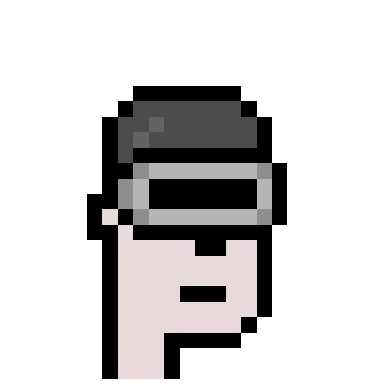

In [14]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: male, frown, muttonchops, knittedCap, regularShades
torch.Size([127964])
Shape: torch.Size([4, 24, 24])


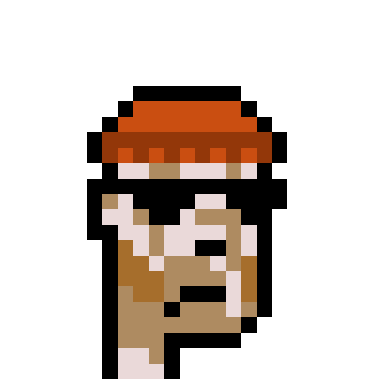

In [15]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: female, rosyCheeks, stringyHair
torch.Size([127964])
Shape: torch.Size([4, 24, 24])


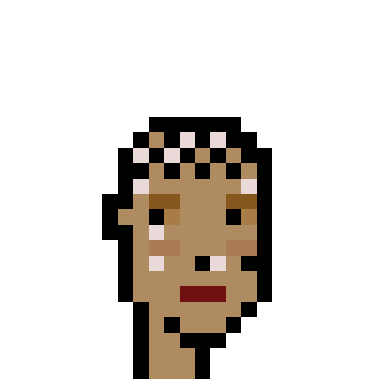

In [16]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: male, fedora, frontBeardDark, vr
torch.Size([127964])
Shape: torch.Size([4, 24, 24])


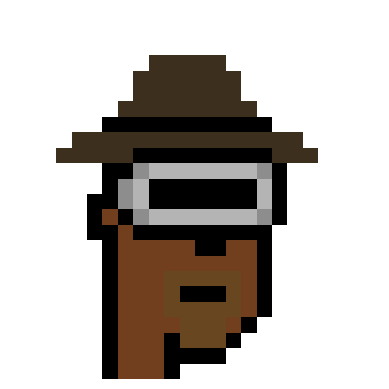

In [17]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: female, clownHairGreen, blackLipstick
torch.Size([127964])
Shape: torch.Size([4, 24, 24])


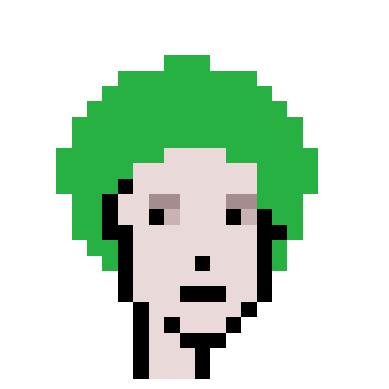

In [18]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


## Reconstruction

In [19]:
def reconstruct_punk(idx):
    punk = I.get_punk_tensor(idx)
    p = DS.rgba_to_one_hot(punk, dataset.mapper)
    p = p.unsqueeze(0)
    p = p.to(device)

    _, labels = dataset[idx]
    l = labels.unsqueeze(0)
    l = l.to(device)
    enabled_features = [k for k,v in zip(dataset._label_keys, labels) if v.item() == 1]

    model.eval()
    with torch.no_grad():
        reconstructed, mu, logvar = model.forward(p, l)

    recon_punk = reconstructed[0].cpu()
    recon_punk = recon_punk[:-classes_dim].view((222, 24, 24))
    recon_punk = DS.one_hot_to_rgba(recon_punk, dataset.mapper)

    return punk, recon_punk, enabled_features


def draw_two(img1, img2):
    page_size = 2
    view_x, view_y = 4*page_size, 2*page_size
    fig = plt.figure(figsize=(view_x, view_y))
    fig.add_subplot(1, 2, 1)
    plt.imshow(transforms.functional.to_pil_image(img1))
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(transforms.functional.to_pil_image(img2))
    plt.axis('off')
    plt.show()


### 5 Reconstructions

Features: female, rosyCheeks, darkHair, cigarette


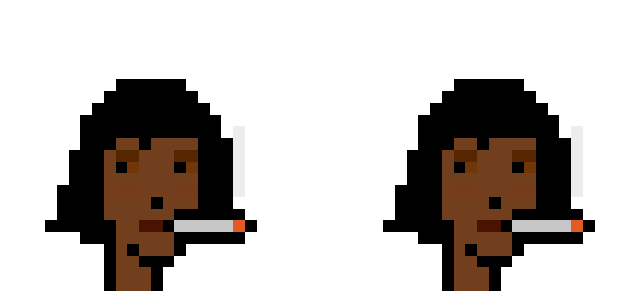

In [20]:
punk, recon_punk, features = reconstruct_punk(1000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: female, stringyHair, purpleLipstick, earring


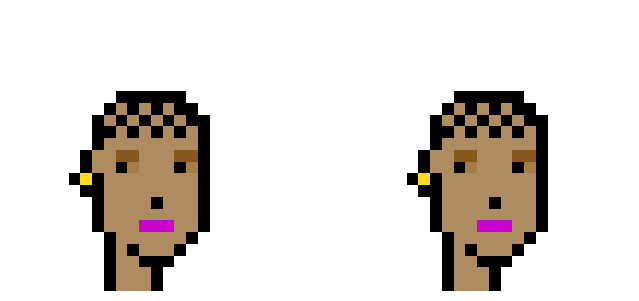

In [21]:
punk, recon_punk, features = reconstruct_punk(2001)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)


Features: female, wildWhiteHair, greenEyeShadow, hotLipstick


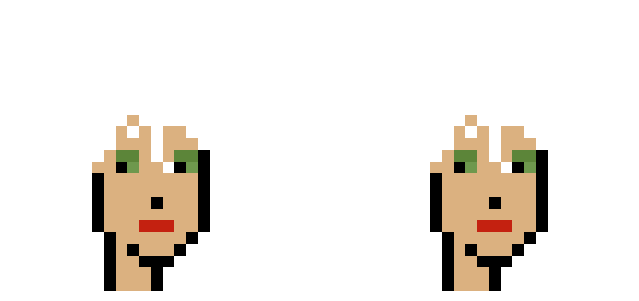

In [22]:
punk, recon_punk, features = reconstruct_punk(5000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: male, rosyCheeks, mustache, vr, cap, cigarette


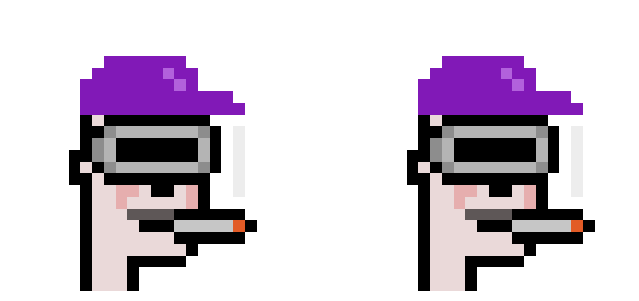

In [23]:
punk, recon_punk, features = reconstruct_punk(8000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: male, handlebars, bandana


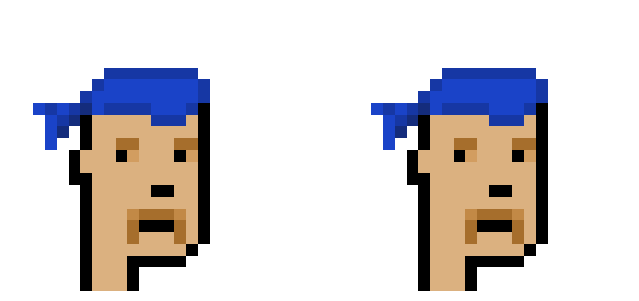

In [24]:
punk, recon_punk, features = reconstruct_punk(1337)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

## Losses

<function matplotlib.pyplot.show(close=None, block=None)>

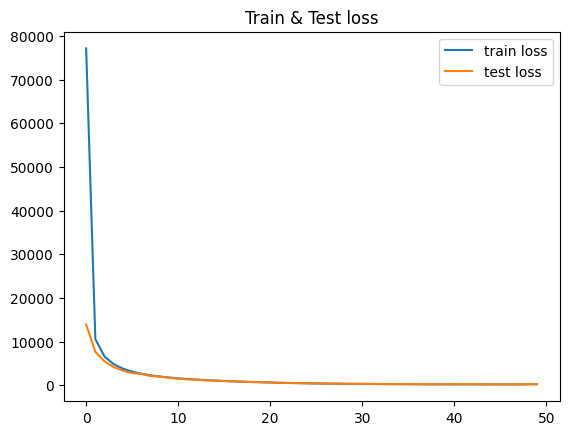

In [25]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show


In [26]:
train_losses


[77151.52860600897,
 10541.634807180852,
 6551.786305529006,
 4803.100023202017,
 3768.2106353543327,
 3088.6697928787125,
 2611.8837706653785,
 2253.9478357193316,
 1967.5270887875388,
 1749.5105032413564,
 1561.0630960667388,
 1400.8645425350107,
 1272.736192743829,
 1155.4393644941615,
 1047.9653294340094,
 944.0995373015708,
 868.6171594714442,
 796.9090920306267,
 721.0137811755458,
 656.2521329839179,
 601.1364211495041,
 540.7555355315512,
 492.8528415328222,
 459.6227161596853,
 421.9206736679618,
 386.75363640751397,
 355.2096762149892,
 335.5943620289471,
 302.7791222917273,
 283.261239126219,
 273.6272298664066,
 267.043338694471,
 242.87913970406174,
 221.32628012041673,
 204.17746945644947,
 203.93166588046026,
 190.47764124768847,
 178.70491468821857,
 177.37343546008387,
 178.86843574469816,
 169.94032196964778,
 170.64840907915263,
 168.13083609452485,
 162.71975643076794,
 168.1163535693013,
 162.28065382504295,
 162.88459372013173,
 152.90746370951334,
 183.3975852127

In [27]:
test_losses


[13882.986534118652,
 7644.089614868164,
 5443.569339752197,
 4136.347888946533,
 3327.989221572876,
 2785.20320892334,
 2556.118549346924,
 2072.896056175232,
 1999.0212297439575,
 1661.2967739105225,
 1490.3608655929565,
 1336.872052192688,
 1224.383454322815,
 1110.5146932601929,
 1041.9022951126099,
 946.0485124588013,
 868.7338700294495,
 777.8195104598999,
 721.8183116912842,
 687.3260431289673,
 607.895400762558,
 538.0652031898499,
 504.6529083251953,
 469.66028690338135,
 430.7246036529541,
 385.5478663444519,
 382.0968313217163,
 359.4962911605835,
 333.8141267299652,
 305.69251680374146,
 310.03419530391693,
 274.2157917022705,
 265.0300235748291,
 249.1834362745285,
 267.51385951042175,
 245.08794355392456,
 218.63839042186737,
 217.7055253982544,
 217.2268352508545,
 208.39040100574493,
 237.70475363731384,
 207.56077766418457,
 253.02698135375977,
 183.4319325685501,
 203.7936499118805,
 189.91076290607452,
 182.03692185878754,
 197.24656105041504,
 223.9656035900116,
 23